In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import stats
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

import seaborn as sns
import gseapy as gp
import matplotlib.colors as mcolors

In [2]:
fdata = ad.read_h5ad("./RNA/Multitime_sorted.h5")
cdata = ad.read_h5ad("./RNA/Multitime.fixed.guide.h5")

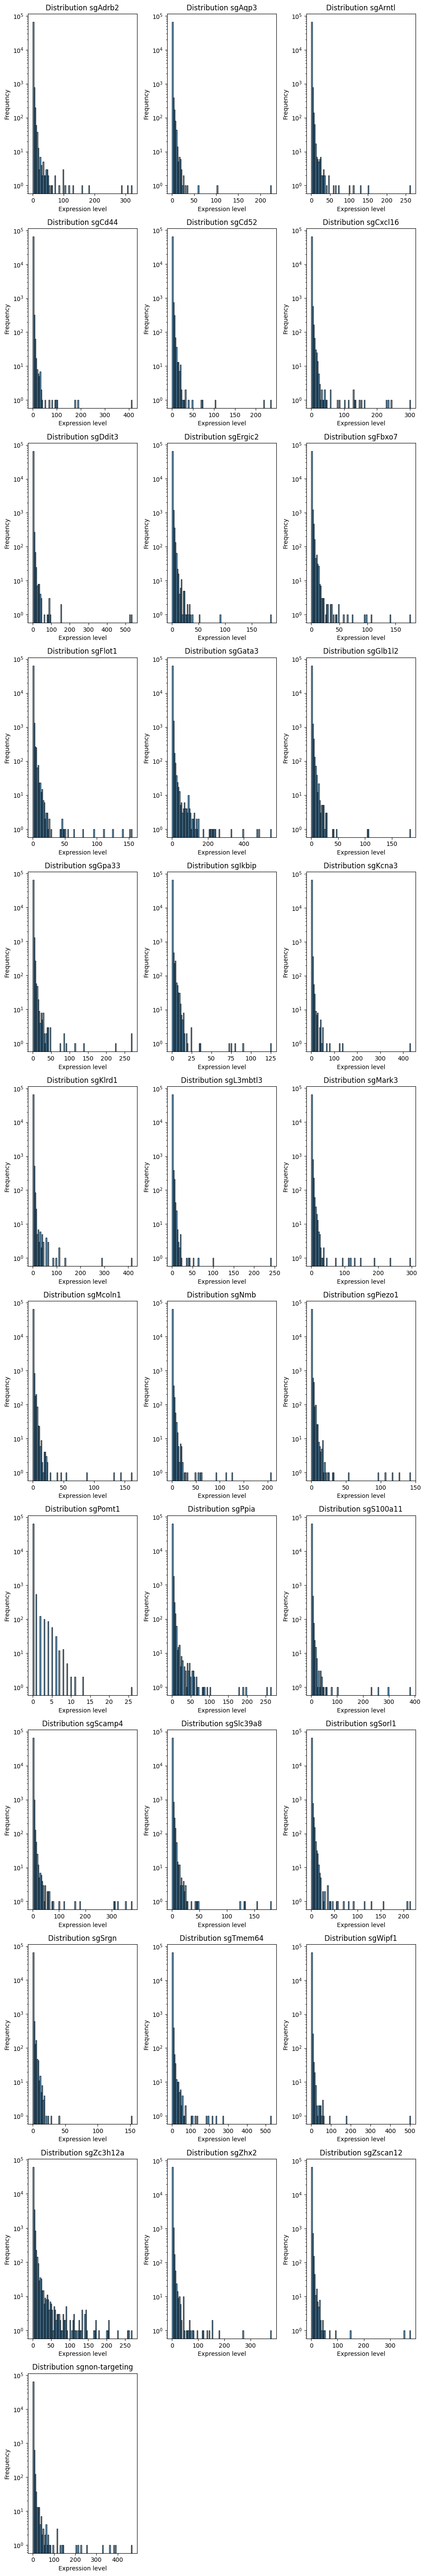

In [6]:
gene_names = cdata.var_names

num_genes = len(gene_names)
cols = 3
rows = (num_genes // cols) + (num_genes % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(10, 5*rows))
axes = axes.flatten()
for i, gene_name in enumerate(gene_names):
    gene_data = cdata[:, gene_name].X
    
    if hasattr(gene_data, "toarray"):
        gene_data = gene_data.toarray()
    
    axes[i].hist(gene_data, bins=100, edgecolor='k', alpha=0.7)
    axes[i].set_title(f'Distribution {gene_name}')
    axes[i].set_xlabel('Expression level')
    axes[i].set_ylabel('Frequency')
    axes[i].set_yscale('log')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [48]:
data = {}
for guide in cdata.var_names:
    guide_sum = np.where(cdata[:, guide].X.toarray() > 0)[0].shape[0]
    guide_without_1 = np.where((cdata[:, guide].X.toarray() <= 1) & (cdata[:, guide].X.toarray() > 0))[0].shape[0]
    guide_without_2 = np.where((cdata[:, guide].X.toarray() <= 2) & (cdata[:, guide].X.toarray() > 1))[0].shape[0]
    guide_without_3 = np.where((cdata[:, guide].X.toarray() <= 3) & (cdata[:, guide].X.toarray() > 2))[0].shape[0]
    guide_without_inf = np.where(cdata[:, guide].X.toarray() > 3)[0].shape[0]
    data[guide] = [guide_sum, guide_without_1, guide_without_2, guide_without_3, guide_without_inf]
perc_df = pd.DataFrame(data, index=['Total', 'only1', '1to2', '2to3', 'more3'])
perc_df

,sgAdrb2,sgAqp3,sgArntl,sgCd44,sgCd52,sgCxcl16,sgDdit3,sgErgic2,sgFbxo7,sgFlot1,...,sgScamp4,sgSlc39a8,sgSorl1,sgSrgn,sgTmem64,sgWipf1,sgZc3h12a,sgZhx2,sgZscan12,sgnon-targeting
Total,7045,2890,4788,4193,4975,5827,7230,4787,5022,5033,...,8513,3562,5499,2577,7976,5303,14653,8665,6067,9969
only1,3946,1716,2871,2521,2863,3328,4165,2971,2976,2956,...,4701,2150,3161,1516,4490,3007,6772,4794,3424,5446
1to2,1330,442,862,721,883,1042,1329,829,783,912,...,1673,569,943,376,1456,941,2879,1661,1067,1943
2to3,624,226,388,296,480,532,742,350,421,399,...,872,286,469,239,719,510,1694,810,577,1042
more3,1145,506,667,655,749,925,994,637,842,766,...,1267,557,926,446,1311,845,3308,1400,999,1538


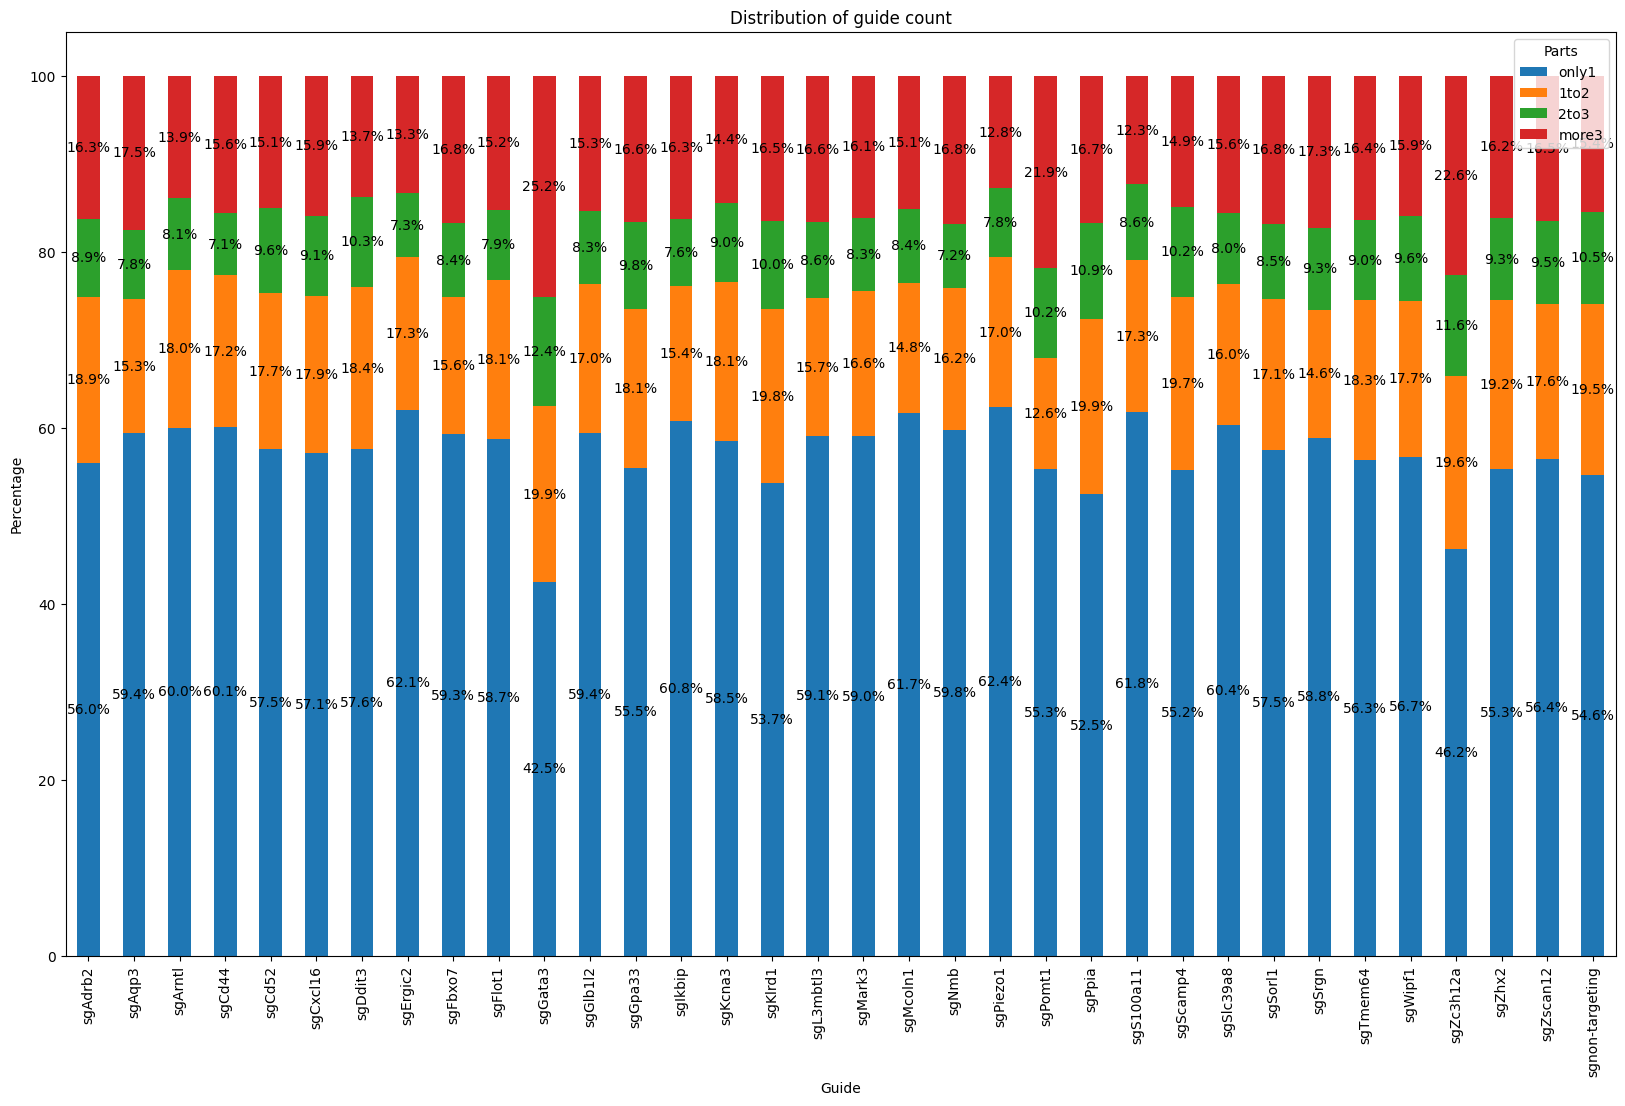

In [58]:
totals = perc_df.iloc[0]
parts = perc_df.iloc[1:]

percentages = parts.div(totals) * 100

ax = percentages.T.plot(kind='bar', stacked=True, figsize=(20, 12))

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.title('Distribution of guide count')
plt.xlabel('Guide')
plt.ylabel('Percentage')
plt.legend(title='Parts')
plt.show()